##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice Aggregate Function Models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/aggregate_function_models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/lattice/blob/master/docs/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/lattice/blob/master/docs/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/lattice/docs/tutorials/aggregate_function_models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

TFL Premade Aggregate Function Models are quick and easy ways to build TFL `keras.Model` instances for learning complex aggregation functions. This guide outlines the steps needed to construct a TFL Premade Aggregate Function Model and train/test it.

## Setup

Installing TF Lattice package:

In [2]:
#@test {"skip": true}
!pip install -U tensorflow tf-keras tensorflow-lattice  pydot graphviz

  Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl.metadata (1.8 kB)


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)


Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl (219 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


Importing required packages:

In [3]:
import tensorflow as tf

import collections
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

2024-12-15 12:22:08.119614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734265328.143959   53652 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734265328.151374   53652 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Downloading the Puzzles dataset:

In [5]:
train_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/train.csv')
train_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            5         108          1               0   
1  NightHawks            5          31          1               0   
2  NightHawks            5          51          1               0   
3  NightHawks            5          88          1               0   
4  NightHawks            4          37          1               0   

   num_helpful  Sales12-18MonthsAgo  
0            6                   81  
1            5                   81  
2            4                   81  
3            4                   81  
4            2                   81

In [6]:
test_dataframe = pd.read_csv(
    'https://raw.githubusercontent.com/wbakst/puzzles_data/master/test.csv')
test_dataframe.head()

puzzle_name  star_rating  word_count  is_amazon  includes_photo  \
0  NightHawks            4         138          0               0   
1  NightHawks            5         115          0               0   
2  NightHawks            5         127          0               0   
3  NightHawks            5         108          1               0   
4  NightHawks            5          31          1               0   

   num_helpful  SalesLastSixMonths  
0            0                  40  
1            0                  40  
2            0                  40  
3            6                  40  
4            5                  40

Extract and convert features and labels

In [7]:
# Features:
# - star_rating       rating out of 5 stars (1-5)
# - word_count        number of words in the review
# - is_amazon         1 = reviewed on amazon; 0 = reviewed on artifact website
# - includes_photo    if the review includes a photo of the puzzle
# - num_helpful       number of people that found this review helpful
# - num_reviews       total number of reviews for this puzzle (we construct)
#
# This ordering of feature names will be the exact same order that we construct
# our model to expect.
feature_names = [
    'star_rating', 'word_count', 'is_amazon', 'includes_photo', 'num_helpful',
    'num_reviews'
]

In [8]:
def extract_features(dataframe, label_name):
  # First we extract flattened features.
  flattened_features = {
      feature_name: dataframe[feature_name].values.astype(float)
      for feature_name in feature_names[:-1]
  }

  # Construct mapping from puzzle name to feature.
  star_rating = collections.defaultdict(list)
  word_count = collections.defaultdict(list)
  is_amazon = collections.defaultdict(list)
  includes_photo = collections.defaultdict(list)
  num_helpful = collections.defaultdict(list)
  labels = {}

  # Extract each review.
  for i in range(len(dataframe)):
    row = dataframe.iloc[i]
    puzzle_name = row['puzzle_name']
    star_rating[puzzle_name].append(float(row['star_rating']))
    word_count[puzzle_name].append(float(row['word_count']))
    is_amazon[puzzle_name].append(float(row['is_amazon']))
    includes_photo[puzzle_name].append(float(row['includes_photo']))
    num_helpful[puzzle_name].append(float(row['num_helpful']))
    labels[puzzle_name] = float(row[label_name])

  # Organize data into list of list of features.
  names = list(star_rating.keys())
  star_rating = [star_rating[name] for name in names]
  word_count = [word_count[name] for name in names]
  is_amazon = [is_amazon[name] for name in names]
  includes_photo = [includes_photo[name] for name in names]
  num_helpful = [num_helpful[name] for name in names]
  num_reviews = [[len(ratings)] * len(ratings) for ratings in star_rating]
  labels = [labels[name] for name in names]

  # Flatten num_reviews
  flattened_features['num_reviews'] = [len(reviews) for reviews in num_reviews]

  # Convert data into ragged tensors.
  star_rating = tf.ragged.constant(star_rating)
  word_count = tf.ragged.constant(word_count)
  is_amazon = tf.ragged.constant(is_amazon)
  includes_photo = tf.ragged.constant(includes_photo)
  num_helpful = tf.ragged.constant(num_helpful)
  num_reviews = tf.ragged.constant(num_reviews)
  labels = tf.constant(labels)

  # Now we can return our extracted data.
  return (star_rating, word_count, is_amazon, includes_photo, num_helpful,
          num_reviews), labels, flattened_features

In [9]:
train_xs, train_ys, flattened_features = extract_features(train_dataframe, 'Sales12-18MonthsAgo')
test_xs, test_ys, _ = extract_features(test_dataframe, 'SalesLastSixMonths')

2024-12-15 12:22:11.542522: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [10]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))

Setting the default values used for training in this guide:

In [11]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 500
MIDDLE_DIM = 3
MIDDLE_LATTICE_SIZE = 2
MIDDLE_KEYPOINTS = 16
OUTPUT_KEYPOINTS = 8

## Feature Configs

Feature calibration and per-feature configurations are set using [tfl.configs.FeatureConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig). Feature configurations include monotonicity constraints, per-feature regularization (see [tfl.configs.RegularizerConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/RegularizerConfig)), and lattice sizes for lattice models.

Note that we must fully specify the feature config for any feature that we want our model to recognize. Otherwise the model will have no way of knowing that such a feature exists. For aggregation models, these features will automaticaly be considered and properly handled as ragged.

### Compute Quantiles

Although the default setting for `pwl_calibration_input_keypoints` in `tfl.configs.FeatureConfig` is 'quantiles', for premade models we have to manually define the input keypoints. To do so, we first define our own helper function for computing quantiles.

In [12]:
def compute_quantiles(features,
                      num_keypoints=10,
                      clip_min=None,
                      clip_max=None,
                      missing_value=None):
  # Clip min and max if desired.
  if clip_min is not None:
    features = np.maximum(features, clip_min)
    features = np.append(features, clip_min)
  if clip_max is not None:
    features = np.minimum(features, clip_max)
    features = np.append(features, clip_max)
  # Make features unique.
  unique_features = np.unique(features)
  # Remove missing values if specified.
  if missing_value is not None:
    unique_features = np.delete(unique_features,
                                np.where(unique_features == missing_value))
  # Compute and return quantiles over unique non-missing feature values.
  return np.quantile(
      unique_features,
      np.linspace(0., 1., num=num_keypoints),
      interpolation='nearest').astype(float)

### Defining Our Feature Configs

Now that we can compute our quantiles, we define a feature config for each feature that we want our model to take as input.

In [13]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='star_rating',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['star_rating'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='word_count',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['word_count'], num_keypoints=5),
    ),
    tfl.configs.FeatureConfig(
        name='is_amazon',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='includes_photo',
        lattice_size=2,
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='num_helpful',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_helpful'], num_keypoints=5),
        # Larger num_helpful indicating more trust in star_rating.
        reflects_trust_in=[
            tfl.configs.TrustConfig(
                feature_name="star_rating", trust_type="trapezoid"),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='num_reviews',
        lattice_size=2,
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints=compute_quantiles(
            flattened_features['num_reviews'], num_keypoints=5),
    )
]

/tmpfs/tmp/ipykernel_53652/285458577.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  pwl_calibration_input_keypoints=compute_quantiles(
/tmpfs/tmp/ipykernel_53652/285458577.py:16: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  pwl_calibration_input_keypoints=compute_quantiles(
/tmpfs/tmp/ipykernel_53652/285458577.py:34: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  pwl_c

## Aggregate Function Model

To construct a TFL premade model, first construct a model configuration from [tfl.configs](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs). An aggregate function model is constructed using the [tfl.configs.AggregateFunctionConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/AggregateFunctionConfig). It applies piecewise-linear and categorical calibration, followed by a lattice model on each dimension of the ragged input. It then applies an aggregation layer over the output for each dimension. This is then followed by an optional output piecewise-linear calibration.

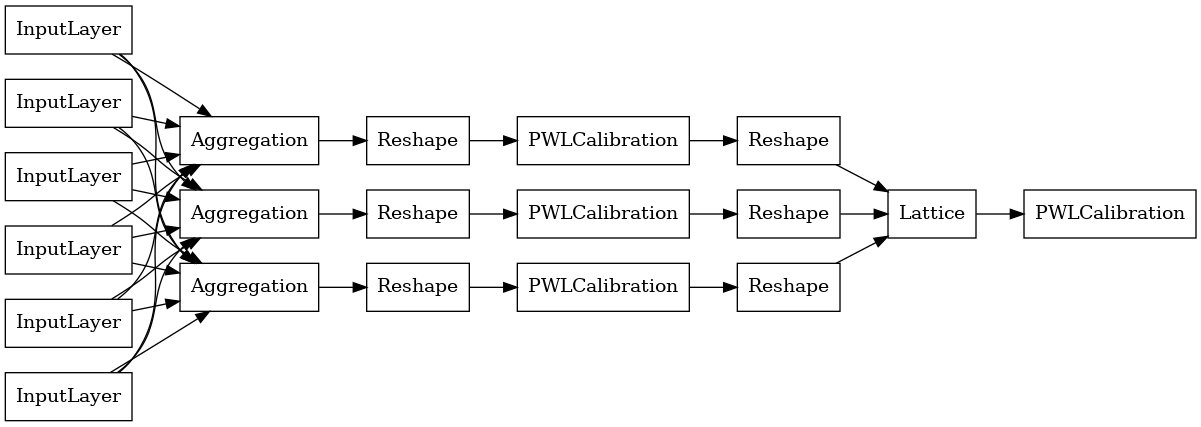

In [14]:
# Model config defines the model structure for the aggregate function model.
aggregate_function_model_config = tfl.configs.AggregateFunctionConfig(
    feature_configs=feature_configs,
    middle_dimension=MIDDLE_DIM,
    middle_lattice_size=MIDDLE_LATTICE_SIZE,
    middle_calibration=True,
    middle_calibration_num_keypoints=MIDDLE_KEYPOINTS,
    middle_monotonicity='increasing',
    output_min=min_label,
    output_max=max_label,
    output_calibration=True,
    output_calibration_num_keypoints=OUTPUT_KEYPOINTS,
    output_initialization=np.linspace(
        min_label, max_label, num=OUTPUT_KEYPOINTS))
# An AggregateFunction premade model constructed from the given model config.
aggregate_function_model = tfl.premade.AggregateFunction(
    aggregate_function_model_config)
# Let's plot our model.
keras.utils.plot_model(
    aggregate_function_model, show_layer_names=False, rankdir='LR')

The output of each Aggregation layer is the averaged output of a calibrated lattice over the ragged inputs. Here is the model used inside the first Aggregation layer:

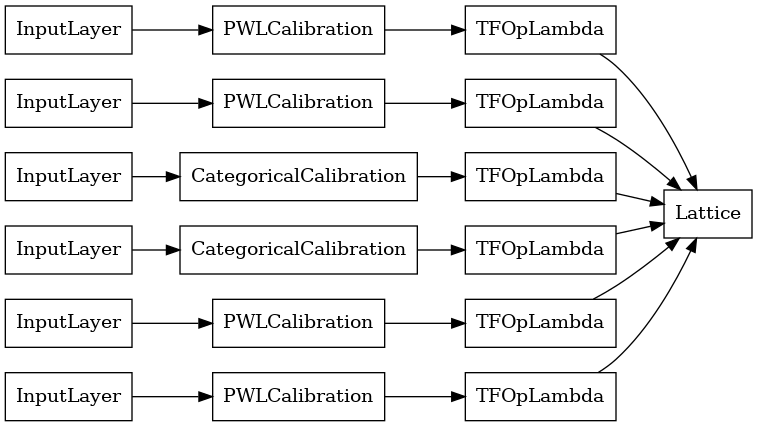

In [15]:
aggregation_layers = [
    layer for layer in aggregate_function_model.layers
    if isinstance(layer, tfl.layers.Aggregation)
]
keras.utils.plot_model(
    aggregation_layers[0].model, show_layer_names=False, rankdir='LR')

Now, as with any other [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), we compile and fit the model to our data.

In [16]:
aggregate_function_model.compile(
    loss='mae',
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
aggregate_function_model.fit(
    train_xs, train_ys, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=False)

After training our model, we can evaluate it on our test set.

In [17]:
print('Test Set Evaluation...')
print(aggregate_function_model.evaluate(test_xs, test_ys))

Test Set Evaluation...


1/7 [===>..........................] - ETA: 8s - loss: 123.8381

7/7 [==============================] - 1s 3ms/step - loss: 46.0650


46.06503677368164
